# Reproducing Figure 3 in Porter et al., 2011

In this example we generate *P* receiver functions for a model that includes either a dipping lower crustal layer or a lower-crustal anisotropic layer. These example reproduce the results of Figure 3 in [Porter et al. (2011)](#references).

Start by importing the necessary packages:

In [1]:
import numpy as np
from pyraysum import prs, Geometry, Model, RC

Define the arrays of slowness and back-azimuth values of the incident `P` wave to use as input in the simulation

/home/wasja/.local/lib/python3.9/site-packages/pyraysum/prs.py:801: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


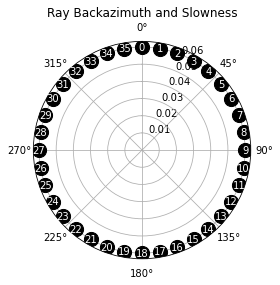

In [2]:
baz = np.arange(0., 360., 10.)
slow = 0.06
geom = Geometry(baz, slow)
_ = geom.plot()

Define the layers of the model as a model object. The values used are found in the caption of Figure 3. Note that $V_S$ can be parameterized either diectly or as $V_P/V_S$, which is what we do here. Also note that values that are constant for all layers can be given as floats. 

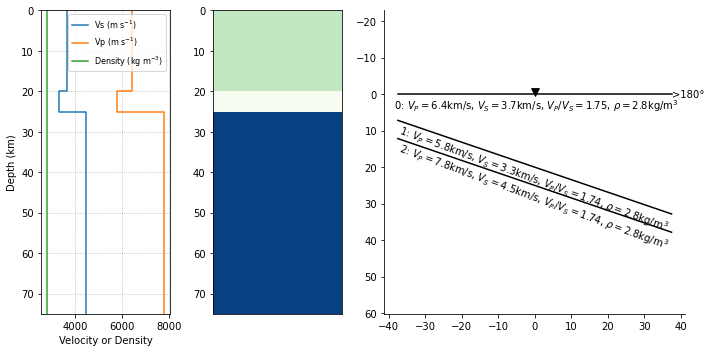

In [3]:
thickn = [20000, 5000, 0]
rho = 2800
vp = [6400, 5800, 7800]
vpvs = [1.75, 1.74, 1.74]
dip = [0, 20, 20]
strike = 90

model = Model(thickn, rho, vp, vpvs=vpvs, strike=strike, dip=dip)
model.plot()

Here we specify the argument `rot=1` to produce seismograms aligned in the `R-T-Z` coordinate system. The default value is `rot=0`, which produces seismograms aligned in the `N-E-Z` coordinate system, which cannot be used to calculate receiver functions. Furthermore, we are interested only in the direct conversions, and therefore specify `mults=0` to avoid dealing with multiples. This is required to reproduce the published examples, although it is good practice to keep all first-order multiples to properly simulate the full Green's functions.

In [4]:
rc = RC(rot=1, mults=0, verbose=False)

Now, let's run the simulation. All bookkeeping is handled internally.

In [5]:
seismogram = prs.run(model, geom, rc)

The function returns a `Seismogram` object whose attributes are the `Model`, `Geometry` of incoming rays, a list of `Streams` as well as all run-time arguments that are used by Raysum:

In [6]:
seismogram.__dict__.keys()

dict_keys(['model', 'geom', 'streams', 'rc'])

We can then use the method `calculate_rfs` to calculate receiver functions:

In [7]:
seismogram.calculate_rfs()

[2 Trace(s) in Stream:
.prs..RFR | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples
.prs..RFT | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples,
 2 Trace(s) in Stream:
.prs..RFR | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples
.prs..RFT | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples,
 2 Trace(s) in Stream:
.prs..RFR | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples
.prs..RFT | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples,
 2 Trace(s) in Stream:
.prs..RFR | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples
.prs..RFT | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples,
 2 Trace(s) in Stream:
.prs..RFR | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:07.475000Z | 40.0 Hz, 300 samples
.prs..RFT | 1970-01-01T00:00:00.000000Z - 19

The receiver functions are stored as an additional attribute of the streamlist object, which is itself a list of `Streams` containing the radial and transverse component RFs:

In [8]:
seismogram.__dict__.keys()

dict_keys(['model', 'geom', 'streams', 'rc', 'rfs'])

We can now filter and plot the results - we specify the key `'rfs'` to work on the receiver functions only. 

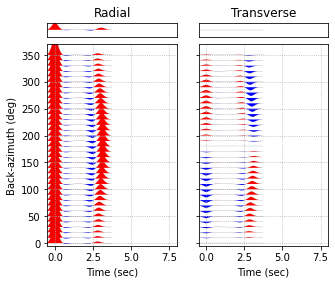

In [9]:
seismogram.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
seismogram.plot('rfs', tmin=-0.5, tmax=8.)

Now let's reproduce the second case with the anisotropic lower crustal layer. In the second case, the second layer (`1` in python indexing) is not tilted, but has a strong anisotropy of -20%. The anisotropy axis trends south (`trend = 180`) and plunges 45 degree (`plunge = 45`). We could define a new model as above. Another possibility is to use use a short command string to change the existing model.

Changed: dip[1] = 0.0
Changed: dip[2] = 0.0
Changed: ani[1] = -20.0
Changed: trend[1] = 180.0
Changed: plunge[1] = 45.0


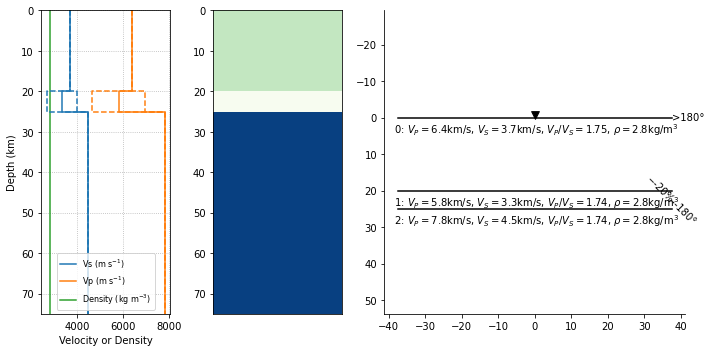

In [10]:
model.change('d1=0; d2=0; a1=-20; tr1=180; pl1=45;')
model.plot()

Instead of two dipping layers, the model now has a thin anisotropic layer at the base of the crust. We again compute synthetic seismograms and use the `rf` argument to process the receiver functions as well.

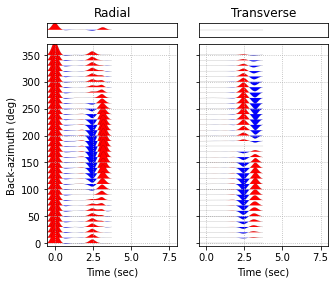

In [11]:
seismogram = prs.run(model, geom, rc, rf=True)

seismogram.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
seismogram.plot('rfs', tmin=-0.5, tmax=8.)

To understand the different phases present we can look e.g. at the receiver function of backazimuth 150°. We look into how the individual phases are called and when they arrive.

The following command tells us, that the negative wiggle arriving at 2.5 seconds is a P-to-S convsersion at the bottom of layer 0 (i.e. the top of the anisotropic layer), whereas the positive wiggle at 3s consits of to S-waves arriving shortly after one another: The smaller wiggle is the P-to-S1 conversion at the bottom of layer 1 (the anistropic layer), and the larger one the P-to-S2 conversion at the same iterface. (Note that the slow S-wave is denoted *T*, to avoid ambiguity with the layer indices.) Both phases travel as an S-wave (here again named *T*) in the topmost layer 0.

['2P1P0T' '2P1S0T' '2P1T0T']
[2.4750537872314453 3.1296849250793457 3.225700855255127]


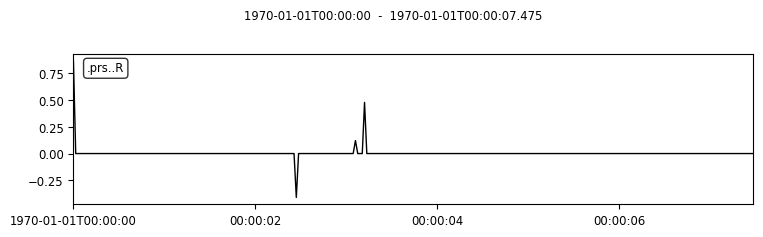

In [12]:
print(seismogram.streams[15][0].stats.phase_descriptors)
print(seismogram.streams[15][0].stats.phase_times)
_ = seismogram.streams[15][0].plot()

On the transverse component, the P-to-S1 conversion has a negative amplitude, while the P-to-S2 conversion has a larger, positive one.

['2P1P0P' '2P1P0S' '2P1S0S' '2P1T0S']
[0.02500009536743164 2.4750537872314453 3.1296849250793457
 3.225700855255127]


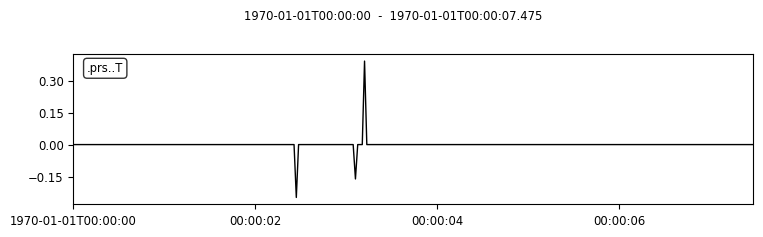

In [13]:
print(seismogram.streams[15][1].stats.phase_descriptors)
print(seismogram.streams[15][1].stats.phase_times)

_ = seismogram.streams[15][1].plot()

## References

* Frederiksen, A.W., & Bostock, M.G. (2000). Modelling teleseismic waves in dipping anisotropic structures. Geophysical Journal International, 141, 401-412. https://doi.org/10.1046/j.1365-246x.2000.00090.x
* Porter, R., Zandt, G., & McQuarrie, N. (2011). Pervasive lower-crustal seismic anisotropy in Southern California: Evidence for underplated schists and active tectonics. Lithosphere, 3(3), 201-220. https://doi.org/10.1130/L126.1